In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))

TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")
print("Policy:", mixed_precision.global_policy())


Policy: <DTypePolicy "mixed_float16">


In [5]:
import kagglehub

path = kagglehub.dataset_download("hassnainzaidi/garbage-classification")
print("Dataset path:", path)

100%|██████████| 123M/123M [00:00<00:00, 169MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/hassnainzaidi/garbage-classification/versions/1


In [6]:
ROOT_DIR = Path(path) / "Garbage classification"
TRAIN_DIR = ROOT_DIR / "train"
VAL_DIR   = ROOT_DIR / "val"
TEST_DIR  = ROOT_DIR / "test"

print("ROOT_DIR:", ROOT_DIR)
print("Train exists:", TRAIN_DIR.exists())
print("Val exists:", VAL_DIR.exists())
print("Test exists:", TEST_DIR.exists())

print("Train folders:", [p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])


ROOT_DIR: /root/.cache/kagglehub/datasets/hassnainzaidi/garbage-classification/versions/1/Garbage classification
Train exists: True
Val exists: True
Test exists: True
Train folders: ['paper', 'glass', 'plastic', 'metal', 'trash', 'cardboard']


In [ ]:
SEED = 42
IMG_SIZE = (320, 320)        # safer than 384 on my free T4 google collab gpu, still high accuracy
BATCH_SIZE_STAGE1 = 32       # frozen backbone stage
BATCH_SIZE_STAGE2 = 8        # fine-tuning stage (prevents OOM)

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_STAGE1,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_STAGE1,
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_STAGE1,
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Num classes:", NUM_CLASSES)


Found 2527 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Num classes: 6


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [11]:
train_ds_ft = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_STAGE2,
    shuffle=True
).prefetch(AUTOTUNE)

val_ds_ft = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_STAGE2,
    shuffle=False
).prefetch(AUTOTUNE)

Found 2527 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.


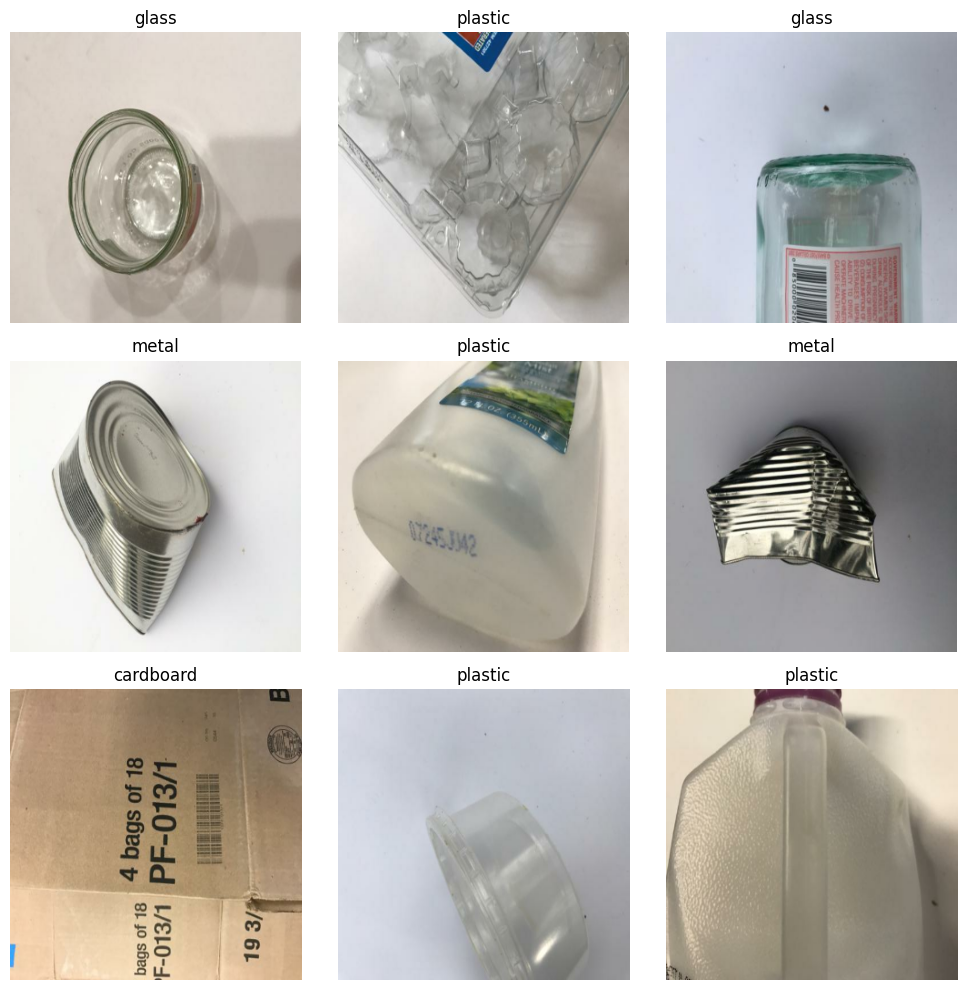

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.1),
], name="augmentation")


In [14]:
preprocess = tf.keras.applications.efficientnet_v2.preprocess_input

backbone = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
)

backbone.trainable = False  # Stage 1: freeze

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess(x)
x = backbone(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# IMPORTANT: dtype float32 so outputs aren't float16 (stability)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 10, 10, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,339,046 (77.59 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [16]:
callbacks_stage1 = [
    keras.callbacks.ModelCheckpoint("best_stage1.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_stage1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 90s 669ms/step - accuracy: 0.5405 - loss: 1.2741 - val_accuracy: 0.8603 - val_loss: 0.5141
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8229 - loss: 0.5506 - val_accuracy: 0.8821 - val_loss: 0.3946
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 439ms/step - accuracy: 0.8546 - loss: 0.4495 - val_accuracy: 0.8963 - val_loss: 0.3415
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 433ms/step - accuracy: 0.8716 - loss: 0.3961 - val_accuracy: 0.9019 - val_loss: 0.3126
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - accuracy: 0.8725 - loss: 0.3680 - val_accuracy: 0.9082 - val_loss: 0.2902
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 435ms/step - accuracy: 0.8801 - loss: 0.3508 - val_accuracy: 0.9121 - val_loss: 0.2697
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 434ms/step - accuracy: 0.8937 - loss: 0.3279 - val_accuracy: 0.9169 - val_loss: 0.2540
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.8921 - loss: 0.3207 - val_accu

In [ ]:
backbone.trainable = True

for layer in backbone.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [19]:
callbacks_stage2 = [
    keras.callbacks.ModelCheckpoint("best_finetuned.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, mode="max"),
]

history2 = model.fit(
    train_ds_ft,
    validation_data=val_ds_ft,
    epochs=30,
    callbacks=callbacks_stage2
)


Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 211s 390ms/step - accuracy: 0.9020 - loss: 0.2656 - val_accuracy: 0.9763 - val_loss: 0.0850 - learning_rate: 2.0000e-05
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 86s 272ms/step - accuracy: 0.9571 - loss: 0.1266 - val_accuracy: 0.9877 - val_loss: 0.0427 - learning_rate: 2.0000e-05
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 88s 278ms/step - accuracy: 0.9816 - loss: 0.0647 - val_accuracy: 0.9964 - val_loss: 0.0162 - learning_rate: 2.0000e-05
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 88s 280ms/step - accuracy: 0.9896 - loss: 0.0352 - val_accuracy: 0.9968 - val_loss: 0.0121 - learning_rate: 2.0000e-05
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 95s 302ms/step - accuracy: 0.9855 - loss: 0.0376 - val_accuracy: 0.9972 - val_loss: 0.0144 - learning_rate: 2.0000e-05
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 94s 298ms/step - accuracy: 0.9919 - loss: 0.0281 - val_accuracy: 0.9976 - val_loss: 0.0095 - learning_rate: 2.0000e-05
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 121s 

In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.9987 - loss: 0.0063
Test accuracy: 0.9988127946853638


79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 263ms/step
              precision    recall  f1-score   support

   cardboard     1.0000    1.0000    1.0000       403
       glass     0.9980    0.9960    0.9970       501
       metal     0.9976    1.0000    0.9988       410
       paper     1.0000    1.0000    1.0000       594
     plastic     0.9979    0.9979    0.9979       482
       trash     1.0000    1.0000    1.0000       137

    accuracy                         0.9988      2527
   macro avg     0.9989    0.9990    0.9990      2527
weighted avg     0.9988    0.9988    0.9988      2527



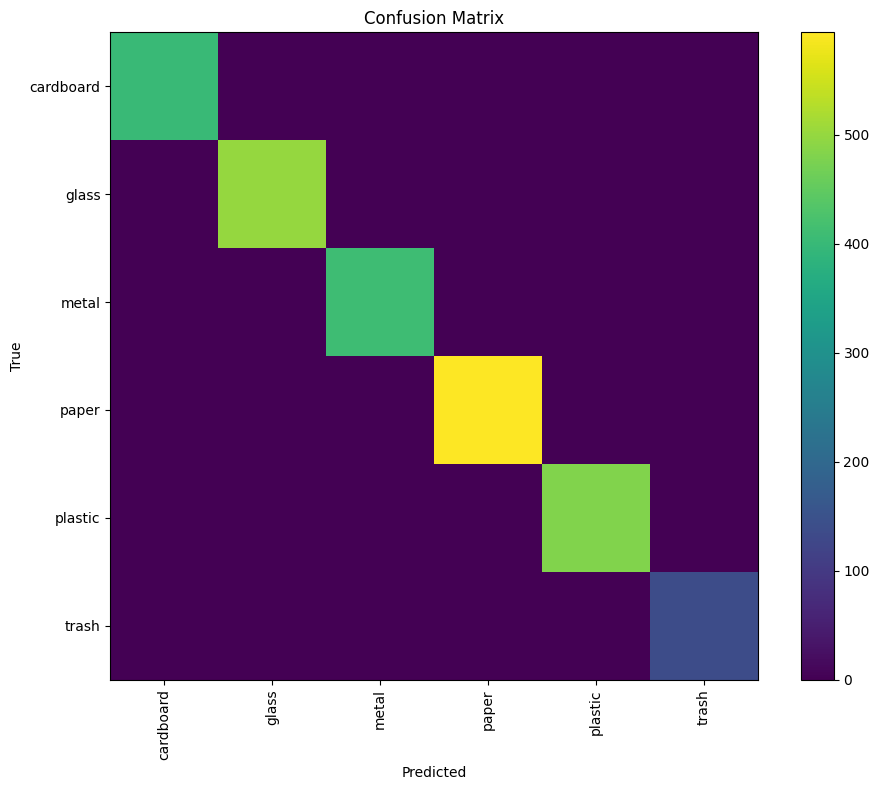

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(NUM_CLASSES), class_names, rotation=90)
plt.yticks(range(NUM_CLASSES), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

In [22]:
model.save("waste_sorting_model.keras")
print("Saved: waste_sorting_model.keras")


Saved: waste_sorting_model.keras


In [23]:
from google.colab import files
files.download("waste_sorting_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>